**Gestione Energetica ed Automazione negli Edifici (GEAE) A.A. 2024/2025**

*Tutto il materiale didattico messo a disposizione degli studenti (compresi script, markdown, presentazioni, video e Virtual Classroom) è da utilizzarsi esclusivamente per scopi didattici e nell’ambito del corso di “gestione energetica e automazione negli edifici”. È vietata ogni forma di utilizzo diverso, redistribuzione e pubblicazione on line. Per ogni eventuale dubbio o richiesta contattare il titolare del corso prof. Alfonso Capozzoli a alfonso.capozzoli@polito.it*

# Time series analytics

## Introduction and pre-processing

### Importing necessary libraries

Install the library `scikit-learn` before proceeding. Open terminal and run the following command:

`pip install scikit-learn`


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

### Importing data

In [2]:
df = pd.read_csv('../data/pydata.csv', parse_dates=['date_time'])
df_info = pd.read_csv('../data/df_info.csv')

### Introducing missing values

In the following cells missing values are added to a specific column of `df`.

In [3]:
np.random.seed(0)  # For reproducibility
missing_indices = np.random.choice(df.index, size=200, replace=False)
df.loc[missing_indices, 'energy_h'] = np.nan

1. **`np.random.seed(0)`**
   - This line sets the seed for NumPy's random number generator.
   - Setting a seed ensures that the random numbers generated are the same each time you run the code, making your results reproducible. In other words, every time you execute the code, the same "random" indices will be selected.
   - This is particularly important when sharing your code with others or when debugging, as it helps maintain consistency in the output.

2. **`missing_indices = np.random.choice(df.index, size=200, replace=False)`**
   - Here, we are selecting 200 random indices from the dataframe (`df`) using `np.random.choice`.
   - **`df.index`**: Represents all the row indices in the dataframe `df`. We are selecting from the entire range of available rows.
   - **`size=200`**: Specifies that we want to select 200 random indices.
   - **`replace=False`**: Indicates that each index can only be selected once, ensuring that we don't choose duplicate rows. This means that the indices selected will all be unique.

3. **`df.loc[missing_indices, 'energy_h'] = np.nan`**
   - We are using `df.loc` to locate specific rows based on `missing_indices` and modify their value in the column `'energy_h'`.
   - **`missing_indices`**: The list of randomly selected row indices, which will be used to determine which rows should have their values updated.
   - **`'energy_h'`**: Specifies the column we are interested in modifying.
   - **`np.nan`**: Sets the selected rows in the `'energy_h'` column to `NaN` (Not a Number), which represents missing values.
   - This step is often used to simulate missing data for testing imputation techniques or evaluating how algorithms handle incomplete data.

### Visualizing the time series with a heatmap/carpetplot

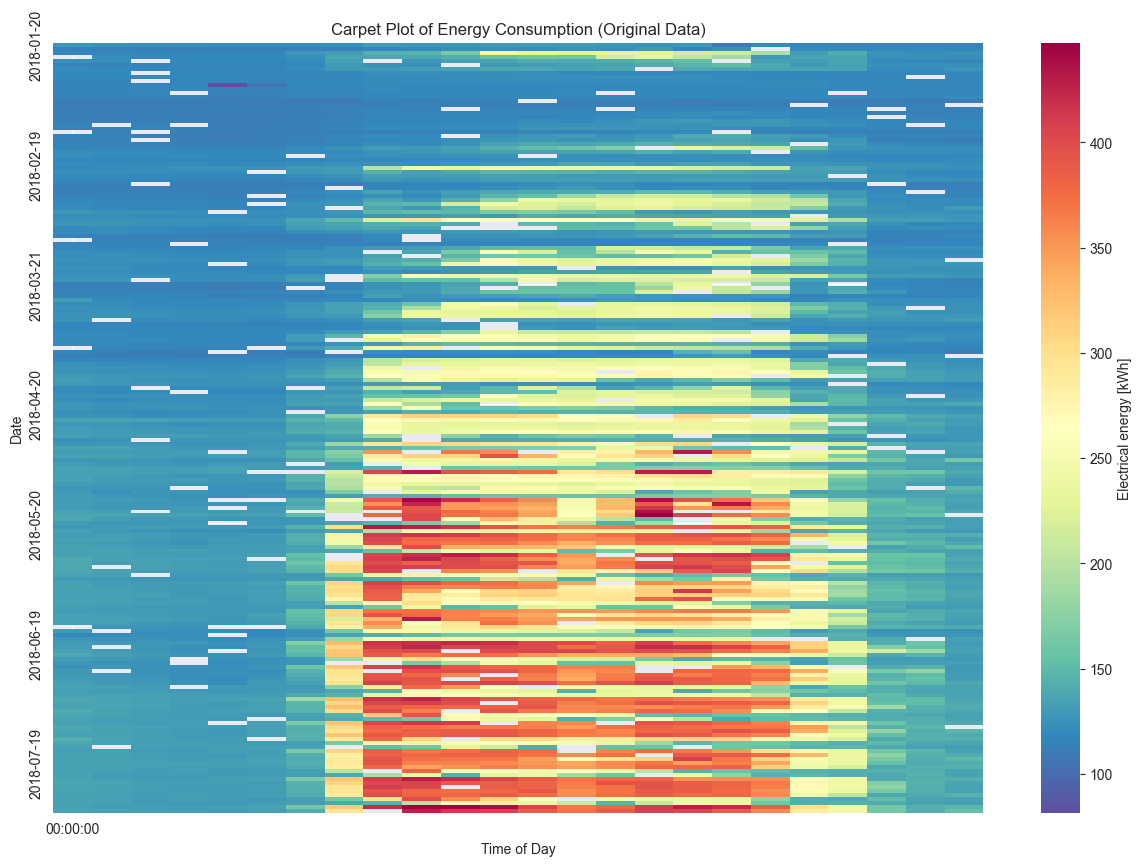

In [4]:
df['date'] = df['date_time'].dt.date
df['time'] = df['date_time'].dt.time
pivot_original = df.pivot_table(index='date', columns='time', values='energy_h')
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_original, cmap='Spectral_r', cbar_kws={'label': 'Electrical energy [kWh]'}, xticklabels=48, yticklabels=30)
plt.title('Carpet Plot of Energy Consumption (Original Data)')
plt.xlabel('Time of Day')
plt.ylabel('Date')
plt.show()

1. **`pydata['date'] = pydata['date_time'].dt.date`**
   - This line creates a new column called `'date'` in the `pydata` DataFrame.
   - **`pydata['date_time']`** refers to an existing column that contains datetime values.
   - **`.dt.date`** extracts the date part from each datetime entry (i.e., year, month, and day) and stores it in the `'date'` column.

2. **`pydata['time'] = pydata['date_time'].dt.time`**
   - This line creates another new column called `'time'` in the `pydata` DataFrame.
   - **`.dt.time`** extracts the time part from each datetime entry (i.e., hours, minutes, and seconds) and stores it in the `'time'` column.

3. **`pivot_original = pydata.pivot_table(index='date', columns='time', values='energy_h')`**
   - This line creates a pivot table from the `pydata` DataFrame and assigns it to `pivot_original`.
   - **`index='date'`**: The pivot table will use the `'date'` column as its index (rows).
   - **`columns='time'`**: The `'time'` column is used as the columns of the pivot table.
   - **`values='energy_h'`**: The values in the pivot table come from the `'energy_h'` column, which represents energy consumption.
   - The pivot table reshapes the data to show the energy consumption (`'energy_h'`) for each combination of date and time, effectively representing energy usage over time.

4. **`plt.figure(figsize=(15, 10))`**
   - This line initializes a new figure for plotting with a specified size of **15 (width) x 10 (height)** inches, allowing for a clearer visualization of the data.

5. **`sns.heatmap(pivot_original, cmap='Spectral_r', cbar_kws={'label': 'Electrical energy [kWh]'}, xticklabels=48, yticklabels=30)`**
   - This line creates a heatmap using Seaborn (`sns`) to visualize the energy consumption over time.
   - **`pivot_original`**: The pivot table is used as the data source for the heatmap.
   - **`cmap='Spectral_r'`**: Specifies the color map used for the heatmap. `'Spectral_r'` is a reversed version of the `'Spectral'` colormap, providing a gradient that represents different levels of energy consumption.
   - **`cbar_kws={'label': 'Electrical energy [kWh]'}`**: Adds a color bar to the heatmap with a label indicating that the color scale represents electrical energy consumption in kilowatt-hours.
   - **`xticklabels=48`**: Reduces the number of x-axis (time) labels to **48**. Since there are likely many time intervals, this makes the heatmap more readable.
   - **`yticklabels=30`**: Reduces the number of y-axis (date) labels to **30** to improve readability.

6. **`plt.title('Carpet Plot of Energy Consumption (Original Data)')`**
   - This line sets the title of the plot to **'Carpet Plot of Energy Consumption (Original Data)'**.

7. **`plt.xlabel('Time of Day')`**, **`plt.ylabel('Date')`**
   - This line labels the x-axis and y-axis as **'Time of Day'** and **'Date'** respectively.

8. **`plt.show()`**
   - This line displays the plot, rendering the carpet plot on the screen.

### Handling missing data and visualization

Employ linear interpolation to handle missing data

In [5]:
df['energy_h'] = df['energy_h'].interpolate(method='linear')

Build the heatmap as done above.

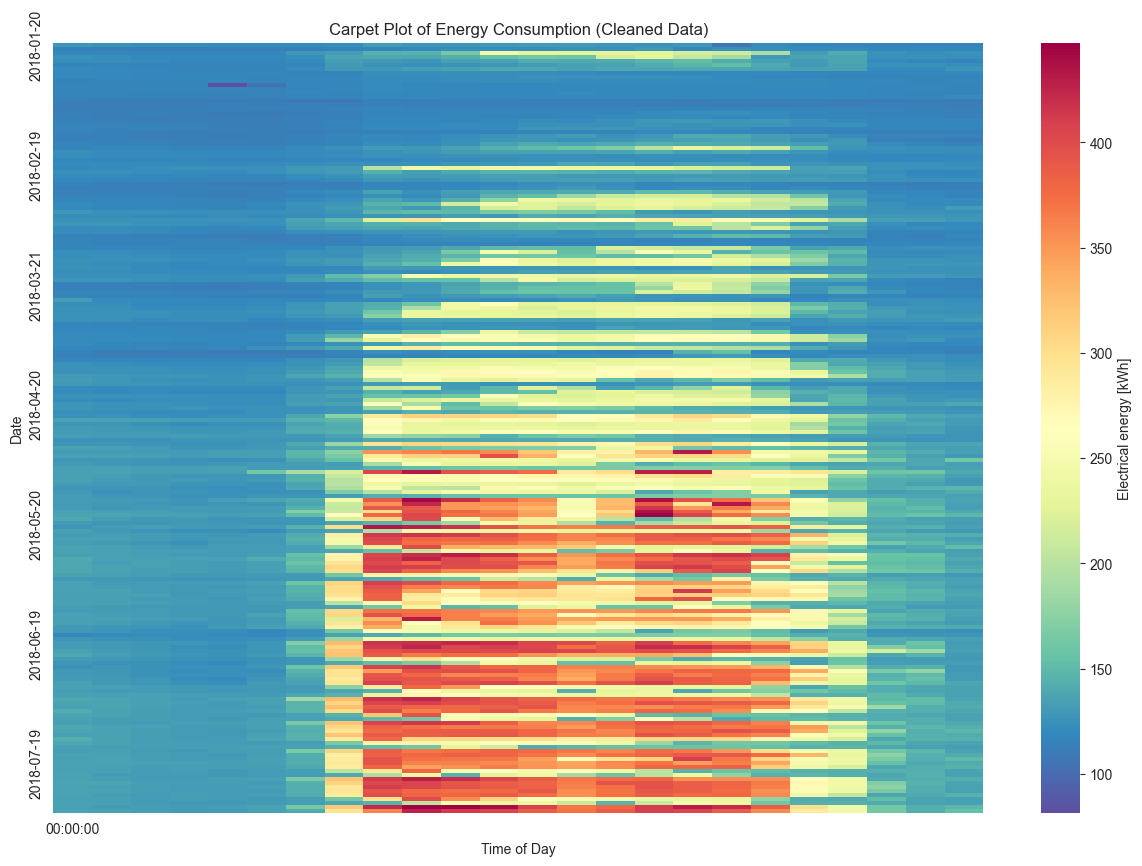

In [6]:
pivot_cleaned = df.pivot_table(index='date', columns='time', values='energy_h')
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_cleaned, cmap='Spectral_r', cbar_kws={'label': 'Electrical energy [kWh]'}, xticklabels=48, yticklabels=30)
plt.title('Carpet Plot of Energy Consumption (Cleaned Data)')
plt.xlabel('Time of Day')
plt.ylabel('Date')
plt.show()

## Clustering process

### Defining MxN matrix

In [7]:
df_mxn = pivot_cleaned.copy()
df_mxn.reset_index(inplace=True)

- This line creates a new DataFrame called `df_mxn` by copying the existing DataFrame `pivot_cleaned`.
- **`pivot_cleaned.copy()`**: The `.copy()` method is used to create a **deep copy** of the `pivot_cleaned` DataFrame.
  - A **deep copy** means that `df_mxn` is an entirely separate object in memory, with no links to the original `pivot_cleaned`. Changes made to `df_mxn` will not affect `pivot_cleaned`, and vice versa.
  - This is important if you need to manipulate or modify `df_mxn` without altering the original data in `pivot_cleaned`.

### Data scaling / normalization

In [8]:
data_columns = df_mxn.columns[1:]
df_mxn[data_columns] = df_mxn[data_columns].div(df_mxn[data_columns].max(axis=1), axis=0)

1. **`data_columns = df_mxn.columns[1:]`**
   - This line creates a variable named `data_columns` that holds all the column names of the DataFrame `df_mxn`, **excluding the first column**.
   - **`df_mxn.columns[1:]`**: The `.columns` attribute returns the list of all column names in the DataFrame.
     - **`[1:]`**: This slice operation selects all columns from the **second column onward** (index 1), effectively skipping the first column. This is commonly done when the first column contains non-numerical data or a unique identifier that shouldn't be part of a specific numerical operation.

2. **`df_mxn[data_columns] = df_mxn[data_columns].div(df_mxn[data_columns].max(axis=1), axis=0)`**
   - This line normalizes the values in the `data_columns` of the DataFrame by dividing each value by the maximum value in its respective row.
   - **`df_mxn[data_columns]`**: This selects only the columns defined by `data_columns` for modification.
   - **`.div(...)`**: The `.div()` method is used to perform element-wise division of the DataFrame. Here, each value in `data_columns` is divided by a corresponding value.
     - **`df_mxn[data_columns].max(axis=1)`**: This part computes the **maximum value for each row** (`axis=1`) across the specified `data_columns`.
     - The computed maximum values are used as divisors for all elements in the corresponding rows.
   - **`axis=0`**: This indicates that the division is applied row-wise, where each element in the row is divided by the maximum value for that row.
   - As a result, each value in the `data_columns` will be normalized such that all values are **scaled between 0 and 1**, with the maximum value in each row becoming 1.

### Computing distance matrix

In [9]:
distance_matrix = pdist(df_mxn[data_columns], metric='euclidean')
distance_square_matrix = squareform(distance_matrix)

1. **`distance_matrix = pdist(py_mxn[data_columns], metric='euclidean')`**
   - This line calculates a **pairwise distance matrix** for the rows of the DataFrame `py_mxn` using the `pdist` function from the SciPy library.
   - **`pdist()`**: This function computes the pairwise distances between all rows in the provided dataset.
     - **`py_mxn[data_columns]`**: Specifies the subset of columns in the DataFrame `py_mxn` that you want to use to compute the distances. `data_columns` is a list of selected columns, typically containing numerical values.
     - **`metric='euclidean'`**: Specifies the distance metric to be used. In this case, the **Euclidean distance** is used, which is the straight-line distance between two points in Euclidean space.
   - The output of this function is a **condensed distance matrix**, which is a 1D array containing all the pairwise distances between rows.

2. **`distance_square_matrix = squareform(distance_matrix)`**
   - This line converts the **condensed distance matrix** obtained from `pdist` into a **square distance matrix** using the `squareform` function from the SciPy library.
   - **`squareform()`**: This function takes the 1D condensed distance matrix and converts it into a 2D square matrix.
     - The resulting matrix is **symmetric**, with rows and columns representing the same set of data points (in this case, the rows from `py_mxn`).
     - Each entry `(i, j)` in the matrix represents the distance between row `i` and row `j` of the original data.
   - The **diagonal values** of this square matrix are all zeros, as the distance from a row to itself is always zero.

### Hierarchical(Agglomerative) clustering and dengrogram visualization

In [10]:
linked = linkage(distance_matrix, method='ward')

- This line performs **hierarchical clustering** on the pairwise distances using the `linkage` function from the SciPy library.
- **`linkage()`**: This function is used to compute the hierarchical clustering. It takes a distance matrix and links the observations step-by-step to form a hierarchical tree (dendrogram).
  - **`distance_matrix`**: This is the pairwise distance matrix that was calculated earlier using `pdist()`. It contains the distances between every pair of data points, which serves as the input for clustering.
  - **`method='ward'`**: Specifies the **linkage method** to be used for clustering.

- **`linked`**: The output is an array representing the **linkage matrix**.
  - The linkage matrix contains information about how clusters are merged step-by-step.
  - Each row in the linkage matrix represents a merging step. The columns typically contain:
    1. The indices of the two clusters that were merged.
    2. The distance between the merged clusters.
    3. The number of original data points contained in the newly formed cluster.

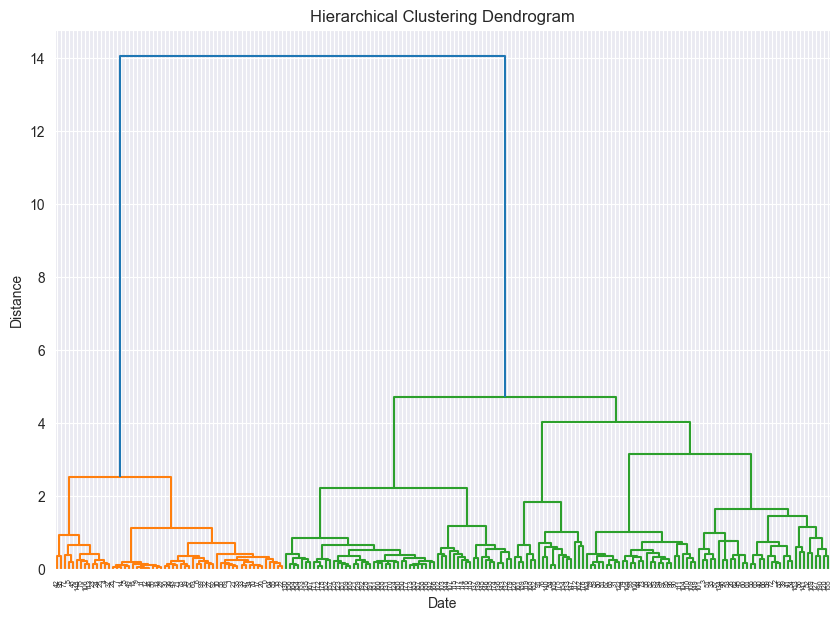

In [11]:
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=df_mxn.index.astype(str).values)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Date')
plt.ylabel('Distance')
plt.show()

- The `dendrogram` function is used to create a visual representation of the hierarchical clustering process. It shows how individual data points are merged into clusters at each level, providing insights into the cluster structure.

### Determining optimal number of clusters

In [12]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [13]:
range_n_clusters = range(3, 16)
silhouette_avg = []
davies_bouldin_avg = []

for n_clusters in range_n_clusters:
    print(f"Evaluating silhouette score and Davies-Bouldin index for {n_clusters} clusters...")
    
    # Create Agglomerative Clustering model with Ward linkage
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    
    # Fit and predict cluster labels
    cluster_labels = clusterer.fit_predict(df_mxn[data_columns])
    
    # Calculate Silhouette Score
    silhouette_avg_score = silhouette_score(df_mxn[data_columns], cluster_labels)
    silhouette_avg.append(silhouette_avg_score)
    
    # Calculate Davies-Bouldin Index
    davies_bouldin_score_value = davies_bouldin_score(df_mxn[data_columns], cluster_labels)
    davies_bouldin_avg.append(davies_bouldin_score_value)

    print(f"Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg_score:.4f}, Davies-Bouldin Index: {davies_bouldin_score_value:.4f}")


Evaluating silhouette score and Davies-Bouldin index for 3 clusters...
Number of clusters: 3, Silhouette Score: 0.4000, Davies-Bouldin Index: 1.1603
Evaluating silhouette score and Davies-Bouldin index for 4 clusters...
Number of clusters: 4, Silhouette Score: 0.4365, Davies-Bouldin Index: 1.0368
Evaluating silhouette score and Davies-Bouldin index for 5 clusters...
Number of clusters: 5, Silhouette Score: 0.4239, Davies-Bouldin Index: 1.0154
Evaluating silhouette score and Davies-Bouldin index for 6 clusters...
Number of clusters: 6, Silhouette Score: 0.3739, Davies-Bouldin Index: 1.0159
Evaluating silhouette score and Davies-Bouldin index for 7 clusters...
Number of clusters: 7, Silhouette Score: 0.3714, Davies-Bouldin Index: 1.0649
Evaluating silhouette score and Davies-Bouldin index for 8 clusters...
Number of clusters: 8, Silhouette Score: 0.3798, Davies-Bouldin Index: 1.0417
Evaluating silhouette score and Davies-Bouldin index for 9 clusters...
Number of clusters: 9, Silhouette S

**`clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')`**

- This line creates an instance of the **Agglomerative Clustering** model using the `AgglomerativeClustering` class from Scikit-Learn.
  
1. **`AgglomerativeClustering()`**:
   - **`AgglomerativeClustering`** is a **hierarchical clustering algorithm** that builds clusters by iteratively merging smaller clusters based on their similarity.

2. **`n_clusters=n_clusters`**:
   - The **`n_clusters`** parameter specifies the number of clusters to form at the end of the algorithm.
   - The variable `n_clusters` is dynamically set within a loop to evaluate clustering with different numbers of clusters, allowing the model to adjust to different cluster sizes during each iteration.

3. **`linkage='ward'`**:
   - The **`linkage`** parameter defines how the distance between clusters is calculated.
   - **`linkage='ward'`** specifies that the **Ward linkage** method should be used.


**`cluster_labels = clusterer.fit_predict(df_mxn[data_columns])`**

- This line performs the **fitting and prediction** step of the clustering algorithm using the `fit_predict()` method from the `AgglomerativeClustering` model.

1. **`clusterer.fit_predict(df_mxn[data_columns])`**:
   - **`clusterer`**: This refers to the **Agglomerative Clustering model** that was created in the previous line of code.
   - **`.fit_predict()`**: This method is used to both **fit** the clustering model to the data and **predict** the cluster labels in one step.
     - **`fit`**: The `fit()` part of this method fits the model to the input data, meaning it learns the hierarchical structure and groups similar data points into clusters.
     - **`predict`**: The `predict()` part assigns each data point a cluster label, indicating to which cluster each point belongs.
   - **`df_mxn[data_columns]`**: This is the data that will be clustered, where `data_columns` is the subset of columns that contain the relevant numerical data to be used for clustering.
     - This can be a filtered set of features in the DataFrame `df_mxn` that are appropriate for the clustering process.

2. **`cluster_labels`**:
   - The **`cluster_labels`** variable stores the labels assigned by the clustering model to each data point.
   - Each label is an integer that represents the **cluster** to which a particular data point belongs.
   - The length of `cluster_labels` matches the number of rows in `df_mxn[data_columns]`, with each element representing the cluster assignment for that data point.

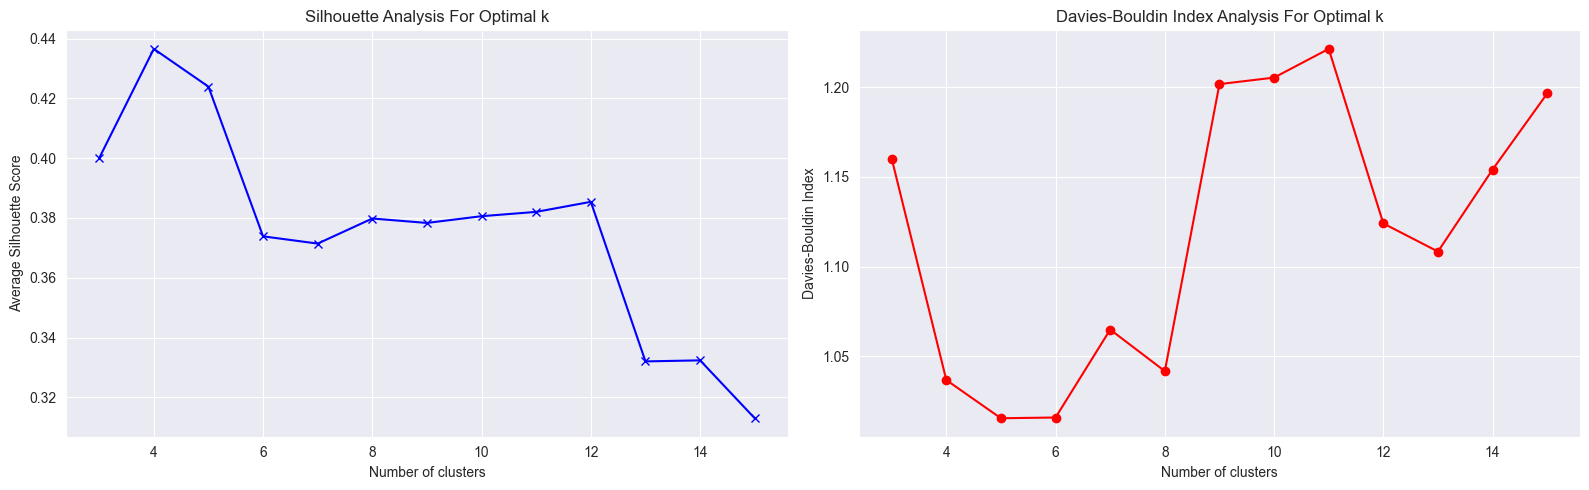

In [14]:
plt.figure(figsize=(16, 5))

# Plot for Silhouette Score
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, silhouette_avg, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')

# Plot for Davies-Bouldin Index
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, davies_bouldin_avg, 'ro-')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index Analysis For Optimal k')

# Show the combined plots
plt.tight_layout()
plt.show()


- **`plt.subplot(1, 2, 1)`**:
  - Sets up the **first subplot** in a grid of **1 row by 2 columns**.
  - This subplot will display the **Silhouette Score** plot.

- **`plt.subplot(1, 2, 2)`**:
  - Sets up the **second subplot** in the **1 row by 2 columns** grid.
  - This subplot will display the **Davies-Bouldin Index** plot.

### Selecting the final number of clusters

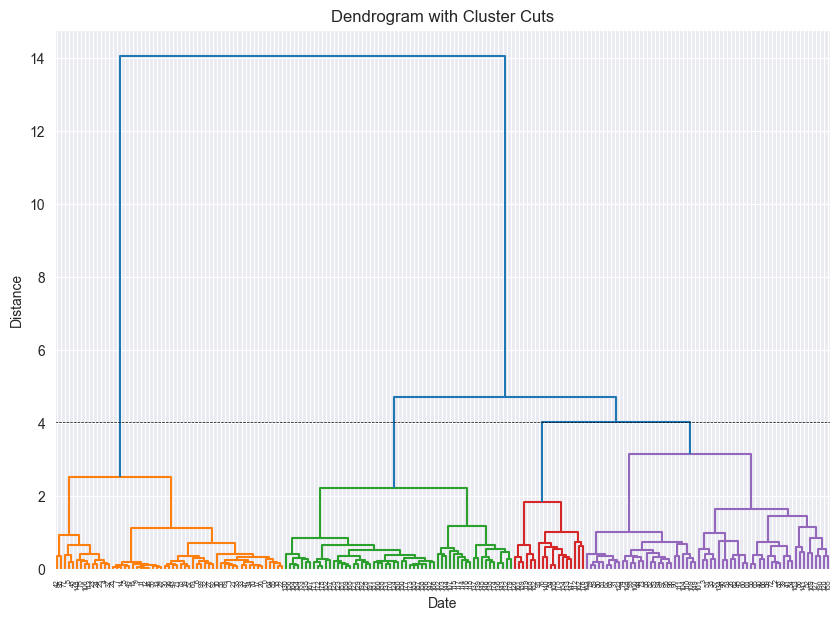

In [15]:
n_clusters = 4
cluster_model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df_mxn['cluster'] = cluster_model.fit_predict(df_mxn[data_columns])

plt.figure(figsize=(10, 7))
dendrogram(linked, labels=df_mxn.index.astype(str).values, color_threshold=linked[-(n_clusters - 1), 2])
plt.title('Dendrogram with Cluster Cuts')
plt.xlabel('Date')
plt.ylabel('Distance')
plt.axhline(y=linked[-(n_clusters - 1), 2], c='k', ls='--', lw=0.5)
plt.show()

### Calculating cluster centroids

In [16]:
melted_py_mxn = df_mxn.melt(id_vars=['date', 'cluster'], var_name='time', value_name='norm_energy_h')
melted_py_mxn['time'] = pd.to_datetime(melted_py_mxn['time'], format='%H:%M:%S')
centroids = melted_py_mxn.groupby(['cluster', 'time']).agg({'norm_energy_h': ['mean', 'std']}).reset_index()
centroids.columns = ['cluster', 'time', 'avg_var', 'sd_var']

The code provided processes a DataFrame (`df_mxn`) by transforming it into a **long format**, calculating **cluster-based statistics**, and renaming the columns to create a new DataFrame (`centroids`).


1. **Melting the DataFrame**

   - **`melted_py_mxn = df_mxn.melt(id_vars=['date', 'cluster'], var_name='time', value_name='norm_energy_h')`**:
     - Converts the DataFrame `df_mxn` from **wide format** to **long format**.
     - **`id_vars=['date', 'cluster']`**:
       - Specifies which columns to keep as **identifier variables**. In this case, `'date'` and `'cluster'` are kept unchanged.
     - **`var_name='time'`**:
       - The other columns (representing times) are melted into a new column named `'time'`.
     - **`value_name='norm_energy_h'`**:
       - The values of the melted columns are stored in a new column named `'norm_energy_h'`.

     - The result is that each row in the new DataFrame represents a **single observation** of energy consumption (`'norm_energy_h'`) at a specific time (`'time'`) for a given date and cluster.

2. **Converting Time Column to Datetime Format**

   - **`melted_py_mxn['time'] = pd.to_datetime(melted_py_mxn['time'], format='%H:%M:%S')`**:
     - Converts the `'time'` column in `melted_py_mxn` to **datetime format**.
     - **`format='%H:%M:%S'`**:
       - Specifies that the time format is **hours:minutes:seconds**.
     - This allows easier manipulation and aggregation of time values later, such as grouping by time.

3. **Grouping by Cluster and Time to Calculate Mean and Standard Deviation**

   - **`centroids = melted_py_mxn.groupby(['cluster', 'time']).agg({'norm_energy_h': ['mean', 'std']}).reset_index()`**:
     - **`groupby(['cluster', 'time'])`**:
       - Groups the DataFrame `melted_py_mxn` by **`'cluster'`** and **`'time'`**.
       - This creates clusters based on time intervals, allowing for calculation of statistics for each cluster at each time point.
     - **`.agg({'norm_energy_h': ['mean', 'std']})`**:
       - Calculates the **mean** and **standard deviation** of the `'norm_energy_h'` column for each group.
       - This provides insight into the **average energy consumption** (`'mean'`) and the **variation** (`'std'`) within each cluster over time.
     - **`.reset_index()`**:
       - Resets the index to convert the grouped DataFrame back into a standard DataFrame, making it easier to work with.

4. **Renaming Columns**

   - **`centroids.columns = ['cluster', 'time', 'avg_var', 'sd_var']`**:
     - Renames the columns in the `centroids` DataFrame for better readability.
     - **`'cluster'`**: Represents the cluster identifier.
     - **`'time'`**: The time of day for each measurement.
     - **`'avg_var'`**: The **average normalized energy consumption** for each cluster at each time.
     - **`'sd_var'`**: The **standard deviation** of the normalized energy consumption, indicating the variation within each cluster at each time.


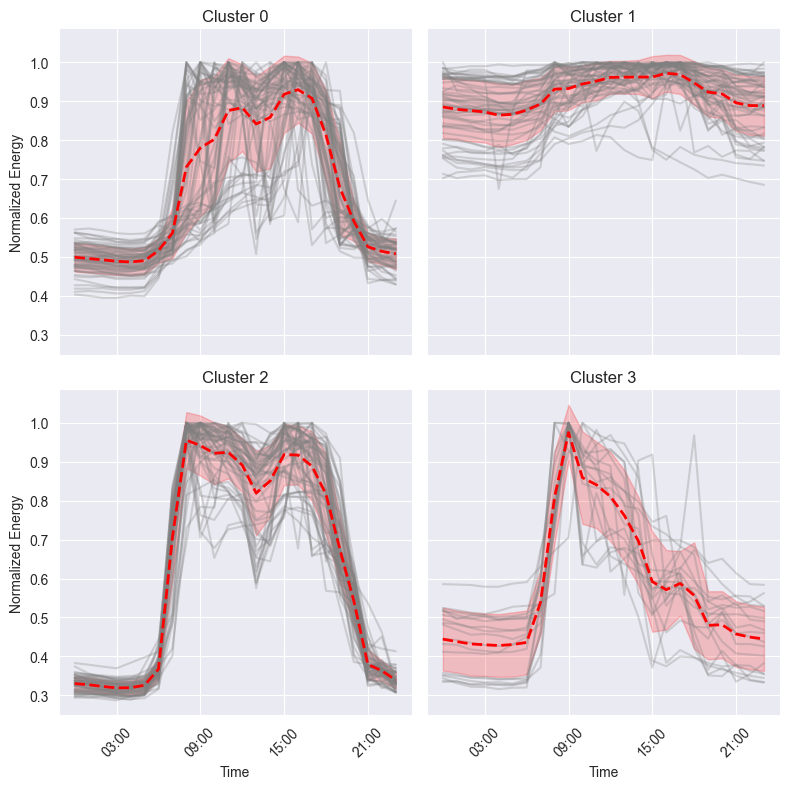

In [17]:
def facet_plot(data, color):
    cluster = data['cluster'].iloc[0]
    for date, group in data.groupby('date'):
        plt.plot(group['time'], group['norm_energy_h'], color='grey', alpha=0.3)
    centroid_data = centroids[centroids['cluster'] == cluster]
    plt.plot(centroid_data['time'], centroid_data['avg_var'], color='red', linestyle='--', linewidth=2)
    plt.fill_between(centroid_data['time'], centroid_data['avg_var'] - centroid_data['sd_var'], centroid_data['avg_var'] + centroid_data['sd_var'], color='red', alpha=0.2)
    plt.title(f'Cluster {cluster}')
    plt.xlabel('Time')
    plt.ylabel('Normalized Energy')
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
    plt.tight_layout()

g = sns.FacetGrid(melted_py_mxn, col='cluster', col_wrap=2, height=4, sharey=True)
g.map_dataframe(facet_plot)
plt.show()

## Classification of cluster labels

### Data preparation

In [18]:
df_info['day'] = df_info['day'].str[:3]
df_mxn['date'] = pd.to_datetime(df_mxn['date'])
df_info['date'] = pd.to_datetime(df_info['date'])
classification_data = pd.merge(df_mxn, df_info)

In [19]:
X = classification_data[['T_avg', 'T_max', 'T_min', 'day']]
y = classification_data['cluster']
X = pd.get_dummies(X, columns=['day'])

- **`X = classification_data[['T_avg', 'T_max', 'T_min', 'day']]`**:
     - Creates a new DataFrame **`X`** containing selected feature variables from `classification_data`.
     - The selected columns include:
       - **`'T_avg'`**: The average temperature.
       - **`'T_max'`**: The maximum temperature.
       - **`'T_min'`**: The minimum temperature.
       - **`'day'`**: The day of the week (as an abbreviated string).
     - These features will be used as **inputs** to train a machine learning model.
- **`y = classification_data['cluster']`**:
     - Creates a new variable **`y`**, which will be used as the **target variable**.
     - **`'cluster'`**: Represents the cluster label for each observation. This target variable is used to predict which cluster a data point belongs to.
- **`X = pd.get_dummies(X, columns=['day'], drop_first=True)`**:
     - Converts the **categorical variable** `'day'` into **dummy variables** (also known as one-hot encoding).
     - **`pd.get_dummies()`**:
       - This function transforms categorical columns into **binary columns**, each representing a unique value of the original categorical column.
       - For example, if `'day'` contains values like "Mon", "Tue", etc., each day will be transformed into a separate column with binary values indicating whether the row corresponds to that particular day.
     - **`columns=['day']`**:
       - Specifies that the **`'day'`** column should be transformed into dummy variables.


In [20]:
clf = DecisionTreeClassifier(min_samples_leaf=10)
clf.fit(X, y)

DecisionTreeClassifier(min_samples_leaf=10)

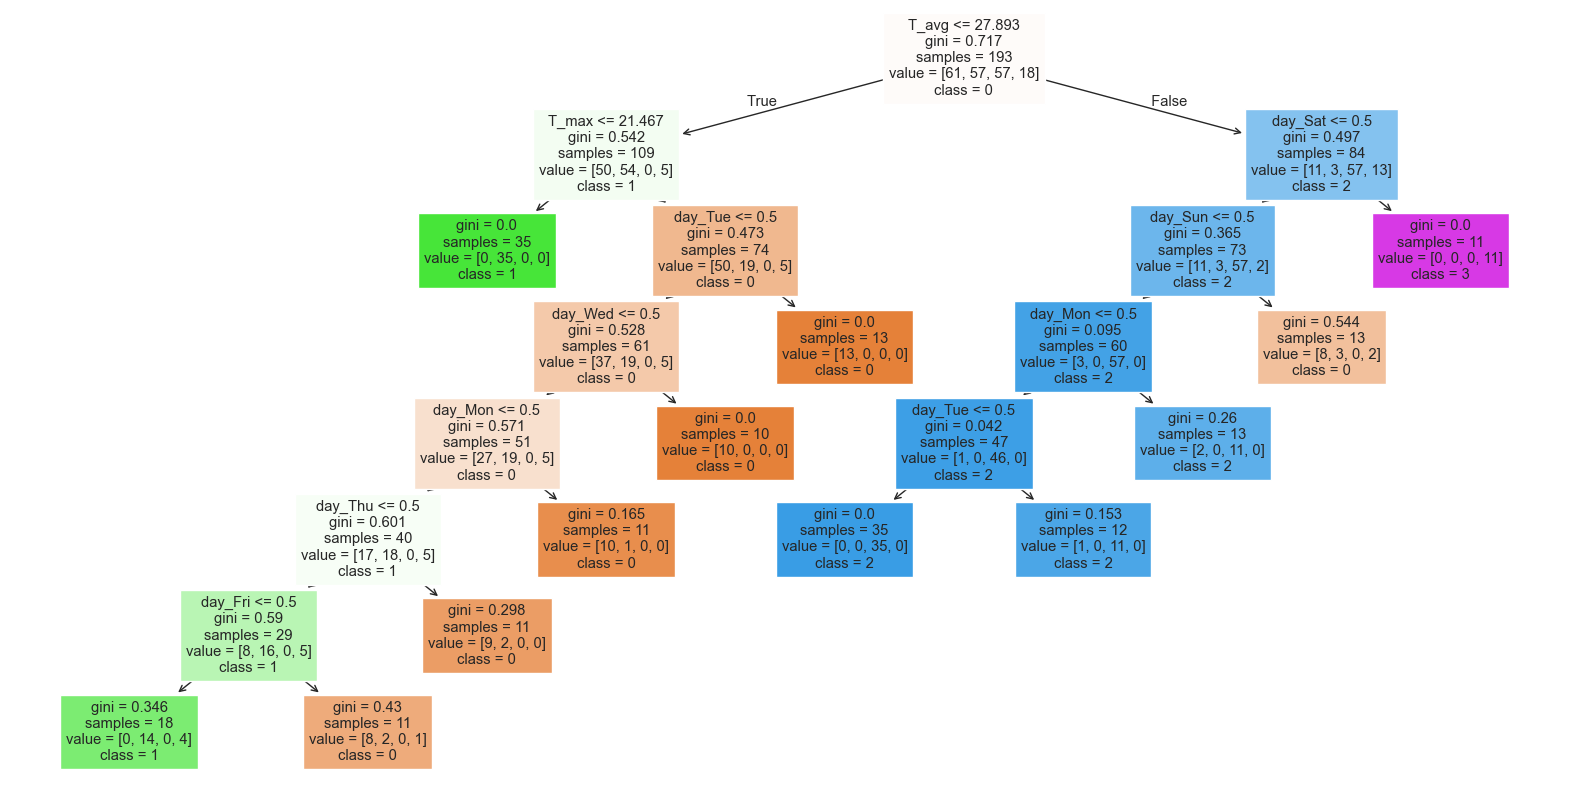

In [21]:
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X.columns, class_names=[str(i) for i in clf.classes_], filled=True)
plt.show()

### Model evaluation

In [22]:
classification_data['pred'] = clf.predict(X)
conf_matrix = confusion_matrix(classification_data['cluster'], classification_data['pred'])
accuracy = accuracy_score(classification_data['cluster'], classification_data['pred']) * 100
recall = recall_score(classification_data['cluster'], classification_data['pred'], average='macro') * 100
precision = precision_score(classification_data['cluster'], classification_data['pred'], average='macro') * 100

In [23]:
print("Confusion Matrix:\n", conf_matrix)
print(f"Accuracy: {accuracy:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"Precision: {precision:.2f}%")

Confusion Matrix:
 [[58  0  3  0]
 [ 8 49  0  0]
 [ 0  0 57  0]
 [ 3  4  0 11]]
Accuracy: 90.67%
Recall: 85.54%
Precision: 92.88%
